# 03a - BigQuery ML (BQML) - Logistic Regression For Classification

In this notebook, BigQuery ML (BQML) is used to create a logistic regression model.

**Logistic Regression**

Logistic Regression is a statistical model for the probability, `p`, of a class.  This is accomplished by fitting a linear combination of the features to the log-odds of the class.  The log-odds is called the logit and is the logarithm ($ln$) of the odds ($\frac{p}{1-p}$).  This is a supervised learning approach where the labels, classes, are learned as function of the features.  While the model is estimating the probability of a class `p` which might be considered regression, the probabilities are used to assign a class which is classification.

Reference:
- [Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression)
- [Supervised Learning](https://en.wikipedia.org/wiki/Supervised_learning)

**BigQuery ML (BQML)**

BigQuery has a number of machine learning algorithms callable directly from SQL.  This gives the convenience of using the common language of `SQL` with statments like `CREATE MODEL …`.  The library of available models is constantly growing and covers supervised, unsupervised, and time series methods as well as functions for evaluation - even anomaly detection from results, explainability and hyperparameter tuning.  A great starting point for seeing the scope of available methods is the [user journey for models](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-e2e-journey).

**Prerequisites:**
- [01 - BigQuery - Table Data Source](../01%20-%20Data%20Sources/01%20-%20BigQuery%20-%20Table%20Data%20Source.ipynb)

**Resources:**
- [BigQuery ML (BQML) Overview](https://cloud.google.com/bigquery-ml/docs/introduction)
- [Overview of BQML methods and workflows](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-e2e-journey)
- [BigQuery](https://cloud.google.com/bigquery)
    - [Documentation:](https://cloud.google.com/bigquery/docs/query-overview)
    - [API:](https://cloud.google.com/bigquery/docs/reference/libraries-overview)
        - [Clients](https://cloud.google.com/bigquery/docs/reference/libraries)
            - [Python SDK:](https://github.com/googleapis/python-bigquery)
            - [Python Library Reference:](https://cloud.google.com/python/docs/reference/bigquery/latest)
- [Vertex AI](https://cloud.google.com/vertex-ai)
    - [Documentation:](https://cloud.google.com/vertex-ai/docs/start/introduction-unified-platform)
    - [API:](https://cloud.google.com/vertex-ai/docs/reference)
        - [Clients:](https://cloud.google.com/vertex-ai/docs/start/client-libraries)
            - [Python SDK:](https://github.com/googleapis/python-aiplatform)
            - [Python Library Reference:](https://cloud.google.com/python/docs/reference/aiplatform/latest)

**Conceptual Flow & Workflow**
<p align="center">
  <img alt="Conceptual Flow" src="../architectures/slides/03a_arch.png" width="45%">
&nbsp; &nbsp; &nbsp; &nbsp;
  <img alt="Workflow" src="../architectures/slides/03a_console.png" width="45%">
</p>

---
## Colab Setup

To run this notebook in Colab click [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/03%20-%20BigQuery%20ML%20(BQML)/03a%20-%20BQML%20Logistic%20Regression.ipynb) and run the cells in this section.  Otherwise, skip this section.

This cell will authenticate to GCP (follow prompts in the popup).

In [1]:
PROJECT_ID = 'learned-pottery-399802' # replace with project ID

In [2]:
try:
    import google.colab
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
    
    #installs
    # Vertex AI GenAI Studio SDK - Update the aiplatform SDK
    !pip install google.cloud.aiplatform -U -q --user
    !pip install --upgrade gcsfs -U -q --user
    !pip install --upgrade google-cloud-bigquery -U -q --user
    !pip install --upgrade google-cloud-bigquery-storage -U -q --user
    
    # Enable Vertex AI For This Project
    !gcloud services enable aiplatform.googleapis.com

    # restart runtime
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)    
except Exception:
    pass

---
## Setup

inputs:

In [3]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'learned-pottery-399802'

In [4]:
REGION = 'us-central1'
EXPERIMENT = 'logistic-regression'
SERIES = 'bqml'

# source data
BQ_PROJECT = PROJECT_ID
BQ_DATASET = 'fraud'
BQ_TABLE = 'fraud_prepped'

# Resources for serving BigQuery Model Exports
TF_DEPLOY_IMAGE = 'us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-3:latest'
XGB_DEPLOY_IMAGE = 'us-docker.pkg.dev/vertex-ai/prediction/xgboost-cpu.0-82:latest'

# Resources for serving BigQuery Model Exports
DEPLOY_COMPUTE = 'n1-standard-4'

# Model Training
VAR_TARGET = 'Class'
VAR_OMIT = 'transaction_id' # add more variables to the string with space delimiters

packages:

In [5]:
from google.cloud import bigquery
from google.cloud import aiplatform
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np

from google.api import httpbody_pb2
import json

clients:

In [6]:
bq = bigquery.Client(project = PROJECT_ID)
aiplatform.init(project = PROJECT_ID, location = REGION)

parameters:

In [7]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
BUCKET = PROJECT_ID
URI = f"gs://{BUCKET}/{SERIES}/{EXPERIMENT}"
RUN_NAME = f'run-{TIMESTAMP}'

BQ_MODEL = f'{SERIES}_{EXPERIMENT}_{TIMESTAMP}'

environment:

In [8]:
DIR = f"temp/{EXPERIMENT}"

!rm -rf {DIR}
!mkdir -p {DIR}

---
## Review Data

The data source here was prepared in [01 - BigQuery - Table Data Source](../01%20-%20Data%20Sources/01%20-%20BigQuery%20-%20Table%20Data%20Source.ipynb).  In this notebook we will use prepared BigQuery table to build a model with BigQuery ML (BQML).

This is a table of 284,807 credit card transactions classified as fradulant or normal in the column `Class`.  In order protect confidentiality, the original features have been transformed using [principle component analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) into 28 features named `V1, V2, ... V28` (float).  Two descriptive features are provided without transformation by PCA:
- `Time` (integer) is the seconds elapsed between the transaction and the earliest transaction in the table
- `Amount` (float) is the value of the transaction

The data preparation included added splits for machine learning with a column named `splits` with 80% for training (`TRAIN`), 10% for validation (`VALIDATE`) and 10% for testing (`TEST`).  Additionally, a unique identifier was added to each transaction, `transaction_id`.  

Review the number of records for each level of Class (VAR_TARGET) for each of the data splits:

In [9]:
query = f"""
    SELECT splits, {VAR_TARGET}, count(*) as n
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    GROUP BY splits, {VAR_TARGET}
"""
print(query)


    SELECT splits, Class, count(*) as n
    FROM `learned-pottery-399802.fraud.fraud_prepped`
    GROUP BY splits, Class



In [10]:
bq.query(query = query).to_dataframe()

,splits,Class,n
0,TEST,0,28423
1,TEST,1,45
2,TRAIN,1,390
3,TRAIN,0,227657
4,VALIDATE,0,28235
5,VALIDATE,1,57


Further review the balance of the target variable (VAR_TARGET) for each split as a percentage of the split:

In [11]:
query = f"""
    WITH
        COUNTS as (SELECT splits, {VAR_TARGET}, count(*) as n FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` GROUP BY splits, {VAR_TARGET})

    SELECT *,
        SUM(n) OVER() as total,
        SAFE_DIVIDE(n, SUM(n) OVER(PARTITION BY {VAR_TARGET})) as n_pct_class,
        SAFE_DIVIDE(n, SUM(n) OVER(PARTITION BY splits)) as n_pct_split,
        SAFE_DIVIDE(SUM(n) OVER(PARTITION BY {VAR_TARGET}), SUM(n) OVER()) as class_pct_total
    FROM COUNTS
"""
print(query)


    WITH
        COUNTS as (SELECT splits, Class, count(*) as n FROM `learned-pottery-399802.fraud.fraud_prepped` GROUP BY splits, Class)

    SELECT *,
        SUM(n) OVER() as total,
        SAFE_DIVIDE(n, SUM(n) OVER(PARTITION BY Class)) as n_pct_class,
        SAFE_DIVIDE(n, SUM(n) OVER(PARTITION BY splits)) as n_pct_split,
        SAFE_DIVIDE(SUM(n) OVER(PARTITION BY Class), SUM(n) OVER()) as class_pct_total
    FROM COUNTS



In [12]:
review = bq.query(query = query).to_dataframe()
review

,splits,Class,n,total,n_pct_class,n_pct_split,class_pct_total
0,VALIDATE,1,57,284807,0.115854,0.002015,0.001727
1,VALIDATE,0,28235,284807,0.099309,0.997985,0.998273
2,TEST,1,45,284807,0.091463,0.001581,0.001727
3,TEST,0,28423,284807,0.099970,0.998419,0.998273
4,TRAIN,1,390,284807,0.792683,0.001710,0.001727
5,TRAIN,0,227657,284807,0.800721,0.998290,0.998273


---
## This Run

In [13]:
print(f'This run will create BQML model: {BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}')
print(f'This run will create Vertex AI model: {BQ_PROJECT}.{BQ_DATASET}.bqml_{SERIES}_{EXPERIMENT}')
print(f'The runs timestamp Is: {TIMESTAMP}')

This run will create BQML model: learned-pottery-399802.fraud.bqml_logistic-regression_20231019060415
This run will create Vertex AI model: learned-pottery-399802.fraud.bqml_bqml_logistic-regression
The runs timestamp Is: 20231019060415


---
## Train Model

Use BigQuery ML to train multiclass logistic regression model:
- [Logistic Regression](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-glm) with BigQuery ML (BQML)
- This uses the `splits` column that notebook `01` created
- `data_split_method = CUSTOM` uses the column in `data_split_col` to assign training data for `FALSE` values and evaluation data for `TRUE` values.
    - in this example the `WHERE splits != 'TEST'` statement filters out the test data and
    - the `CASE` statement maps training data to FALSE and validation data to TRUE
    
This example includes the [training options](https://cloud.google.com/bigquery-ml/docs/create_vertex) to register the resulting model in the [Vertex AI Model Registry](https://cloud.google.com/vertex-ai/docs/model-registry/introduction).

In [14]:
query = f"""
CREATE OR REPLACE MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`
OPTIONS (
        model_type = 'LOGISTIC_REG',
        auto_class_weights = TRUE,
        calculate_p_values = TRUE,
        CATEGORY_ENCODING_METHOD = 'DUMMY_ENCODING',
        input_label_cols = ['{VAR_TARGET}'],
        enable_global_explain = TRUE,
        data_split_col = 'custom_splits',
        data_split_method = 'CUSTOM',
        MODEL_REGISTRY = 'VERTEX_AI',
        VERTEX_AI_MODEL_ID = 'bqml_{SERIES}_{EXPERIMENT}',
        VERTEX_AI_MODEL_VERSION_ALIASES = ['{RUN_NAME}']
    ) AS
SELECT * EXCEPT({','.join(VAR_OMIT.split())}, splits),
    CASE
        WHEN splits = 'TRAIN' THEN FALSE
        ELSE TRUE
    END AS custom_splits
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
WHERE splits != 'TEST'
"""
print(query)


CREATE OR REPLACE MODEL `learned-pottery-399802.fraud.bqml_logistic-regression_20231019060415`
OPTIONS (
        model_type = 'LOGISTIC_REG',
        auto_class_weights = TRUE,
        calculate_p_values = TRUE,
        CATEGORY_ENCODING_METHOD = 'DUMMY_ENCODING',
        input_label_cols = ['Class'],
        enable_global_explain = TRUE,
        data_split_col = 'custom_splits',
        data_split_method = 'CUSTOM',
        MODEL_REGISTRY = 'VERTEX_AI',
        VERTEX_AI_MODEL_ID = 'bqml_bqml_logistic-regression',
        VERTEX_AI_MODEL_VERSION_ALIASES = ['run-20231019060415']
    ) AS
SELECT * EXCEPT(transaction_id, splits),
    CASE
        WHEN splits = 'TRAIN' THEN FALSE
        ELSE TRUE
    END AS custom_splits
FROM `learned-pottery-399802.fraud.fraud_prepped`
WHERE splits != 'TEST'



In [15]:
job = bq.query(query = query)
job.result()

In [16]:
(job.ended-job.started).total_seconds()

159.605

In [85]:
job.total_bytes_processed/1024/1024

69.31514072418213

Add labels to the model in BigQuery:

In [19]:
model = bq.get_model(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}')

In [20]:
model.labels = {'series' : f'{SERIES}', 'experiment' : f'{EXPERIMENT}'}

In [21]:
model = bq.update_model(model, ['labels'])

### Check out this model in BigQuery Console:
- Make sure project selected is the one from this notebook
- Under Explore, expand this project and dataset
- Expand Models and select the model create here

In [22]:
print(f'BigQuery Console for Project:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}')

BigQuery Console for Project:
https://console.cloud.google.com/bigquery?project=learned-pottery-399802


In [23]:
print(f'Direct link to the model in BigQuery:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}&ws=!1m5!1m4!5m3!1s{PROJECT_ID}!2s{BQ_DATASET}!3s{BQ_MODEL}')

Direct link to the model in BigQuery:
https://console.cloud.google.com/bigquery?project=learned-pottery-399802&ws=!1m5!1m4!5m3!1slearned-pottery-399802!2sfraud!3sbqml_logistic-regression_20231019060415


### Check out this model in the Vertex AI Model Registry

In [24]:
print(f'Review the model in the Vertex AI Model Registry:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/models/bqml_{BQ_MODEL}?project={PROJECT_ID}')

Review the model in the Vertex AI Model Registry:
https://console.cloud.google.com/vertex-ai/locations/us-central1/models/bqml_bqml_logistic-regression_20231019060415?project=learned-pottery-399802


### Feature and Training Review

Review the Model Inputs, the feature information, with [ML.FEATURE_INFO](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-feature):

In [25]:
feature_info = bq.query(
    query = f"""
        SELECT *
        FROM ML.FEATURE_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
        """
).to_dataframe()
feature_info

,input,min,max,mean,median,stddev,category_count,null_count,dimension
0,Time,0.000000,172792.000000,94810.805580,85057.000000,47505.063571,<NA>,0,<NA>
1,V1,-56.407510,2.454930,0.001216,0.043414,1.957933,<NA>,0,<NA>
2,V2,-72.715728,21.467203,0.001496,0.063003,1.649632,<NA>,0,<NA>
3,V3,-48.325589,9.382558,0.000135,0.176533,1.518067,<NA>,0,<NA>
4,V4,-5.683171,16.715537,0.001529,-0.045332,1.417221,<NA>,0,<NA>
5,V5,-113.743307,34.801666,0.000295,-0.058665,1.383838,<NA>,0,<NA>
6,V6,-26.160506,73.301626,-0.000991,-0.272396,1.332934,<NA>,0,<NA>
7,V7,-41.506796,120.589494,-0.001558,0.037138,1.239617,<NA>,0,<NA>
8,V8,-73.216718,20.007208,0.001086,0.024173,1.191368,<NA>,0,<NA>
9,V9,-13.434066,15.594995,-0.001462,-0.049482,1.098136,<NA>,0,<NA>


Review the iterations from training with [ML.TRAINING_INFO](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-train):

In [26]:
history = bq.query(
    query = f"""
        SELECT *
        FROM ML.TRAINING_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
        ORDER BY iteration"""
).to_dataframe()
history

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,0,0.682972,0.680146,0.2,8429
1,0,1,0.645592,0.642636,0.4,9246
2,0,2,0.578909,0.575770,0.8,10513
3,0,3,0.472722,0.469428,1.6,11608
4,0,4,0.337548,0.334297,3.2,9355
5,0,5,0.220417,0.217481,6.4,11449
6,0,6,0.162614,0.160004,12.8,10345
7,0,7,0.121768,0.120090,25.6,10506


Plot the loss history:

<Axes: xlabel='iteration'>

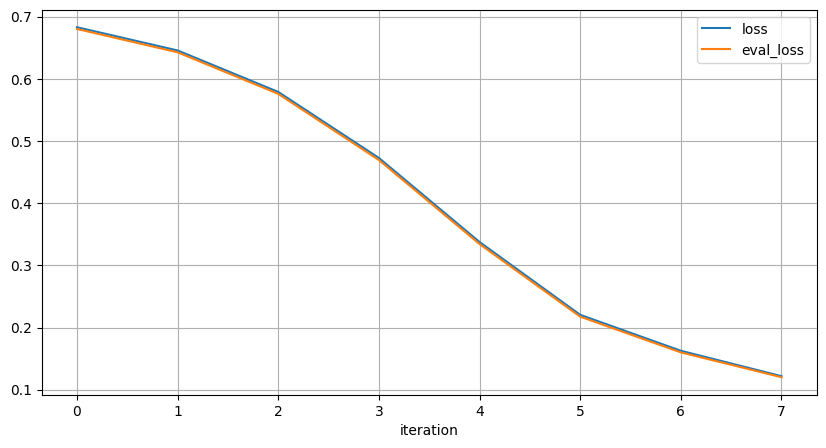

In [27]:
history.plot(x = 'iteration', y = ['loss','eval_loss'], figsize = (10, 5), grid = True)

### Model Weights Review

Retrieve the model parameters with [ML.WEIGHTS](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-weights).

In [28]:
weights = bq.query(
    query = f"""
        SELECT processed_input, weight
        FROM ML.WEIGHTS(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
    """
).to_dataframe()
weights

,processed_input,weight,category_weights
0,Time,-0.000005,[]
1,V1,0.005717,[]
2,V2,0.048682,[]
3,V3,-0.114183,[]
4,V4,0.603413,[]
5,V5,0.122359,[]
6,V6,-0.146667,[]
7,V7,0.021550,[]
8,V8,-0.256492,[]
9,V9,-0.206444,[]


This logistic regression model was trained with the option`calculate_p_values = TRUE` so the [ML.ADVANCED_WEIGHTS](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-advanced-weights) function can be used to retireve weights with associated p-values:

In [29]:
weights = bq.query(
    query = f"""
        SELECT *
        FROM ML.ADVANCED_WEIGHTS(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
    """
).to_dataframe()
weights

,processed_input,category,weight,standard_error,p_value
0,Time,None,-0.000005,2.271379e-07,7.771561e-15
1,V1,None,0.005717,1.149486e-02,6.184622e-01
2,V2,None,0.048682,1.430870e-02,9.931026e-04
3,V3,None,-0.114183,2.339322e-02,1.592963e-05
4,V4,None,0.603413,1.440621e-02,0.000000e+00
5,V5,None,0.122359,1.774023e-02,1.352802e-07
6,V6,None,-0.146667,9.437534e-03,5.295764e-13
7,V7,None,0.021550,3.092484e-02,4.857434e-01
8,V8,None,-0.256492,1.022334e-02,2.220446e-16
9,V9,None,-0.206444,1.643139e-02,1.490830e-11


---
## Evaluate Model

### Metrics

Review the model evaluation statistics on the splits with [ML.EVALUATE](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-evaluate):

In [30]:
query = f"""
SELECT 'TEST' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` WHERE SPLITS='TEST'))
UNION ALL
SELECT 'VALIDATE' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` WHERE SPLITS='VALIDATE'))
UNION ALL
SELECT 'TRAIN' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` WHERE SPLITS='TRAIN'))
"""
bq.query(query = query).to_dataframe()

,SPLIT,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,TEST,0.071556,0.888889,0.981593,0.132450,0.123577,0.991659
1,VALIDATE,0.095819,0.964912,0.981585,0.174326,0.120090,0.995416
2,TRAIN,0.078156,0.900000,0.981675,0.143823,0.123780,0.984269


### Confusion Matrix

Review the confusion matrix for each split with [ML.CONFUSION_MATRIX](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-confusion):

In [31]:
query = f"""
SELECT *
FROM ML.CONFUSION_MATRIX (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TRAIN')
  )
"""
bq.query(query = query).to_dataframe()

,expected_label,_0,_1
0,0,223517,4140
1,1,39,351


In [32]:
query = f"""
SELECT *
FROM ML.CONFUSION_MATRIX (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'VALIDATE')
  )
"""
bq.query(query = query).to_dataframe()

,expected_label,_0,_1
0,0,27716,519
1,1,2,55


In [33]:
query = f"""
SELECT *
FROM ML.CONFUSION_MATRIX (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TEST')
  )
"""
bq.query(query = query).to_dataframe()

,expected_label,_0,_1
0,0,27904,519
1,1,5,40


### ROC Curve

Retrieve the ROC Curve for each split using [ML.ROC_CURVE](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-roc):

In [34]:
query = f"""
SELECT *
FROM ML.ROC_CURVE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TRAIN')
  )
ORDER BY false_positive_rate
"""
train_roc = bq.query(query = query).to_dataframe()
train_roc.head()

,threshold,recall,false_positive_rate,true_positives,false_positives,true_negatives,false_negatives
0,1.000000,0.028205,0.000004,11,1,227656,379
1,0.719289,0.874359,0.008623,341,1963,225694,49
2,0.497822,0.902564,0.018374,352,4183,223474,38
3,0.411581,0.912821,0.028613,356,6514,221143,34
4,0.355625,0.923077,0.038369,360,8735,218922,30


In [35]:
query = f"""
SELECT *
FROM ML.ROC_CURVE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'VALIDATE')
  )
ORDER BY false_positive_rate
"""
val_roc = bq.query(query = query).to_dataframe()
val_roc.head()

,threshold,recall,false_positive_rate,true_positives,false_positives,true_negatives,false_negatives
0,1.000000,0.017544,0.000000,1,0,28235,56
1,0.755920,0.947368,0.008004,54,226,28009,3
2,0.503102,0.964912,0.018098,55,511,27724,2
3,0.414525,0.964912,0.027909,55,788,27447,2
4,0.355144,0.964912,0.038321,55,1082,27153,2


In [36]:
query = f"""
SELECT *
FROM ML.ROC_CURVE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TEST')
  )
ORDER BY false_positive_rate
"""
test_roc = bq.query(query = query).to_dataframe()
test_roc.head()

,threshold,recall,false_positive_rate,true_positives,false_positives,true_negatives,false_negatives
0,1.000000,0.022222,0.000000,1,0,28423,44
1,0.719123,0.866667,0.008444,39,240,28183,6
2,0.495301,0.888889,0.018647,40,530,27893,5
3,0.412688,0.911111,0.028533,41,811,27612,4
4,0.359121,0.911111,0.038490,41,1094,27329,4


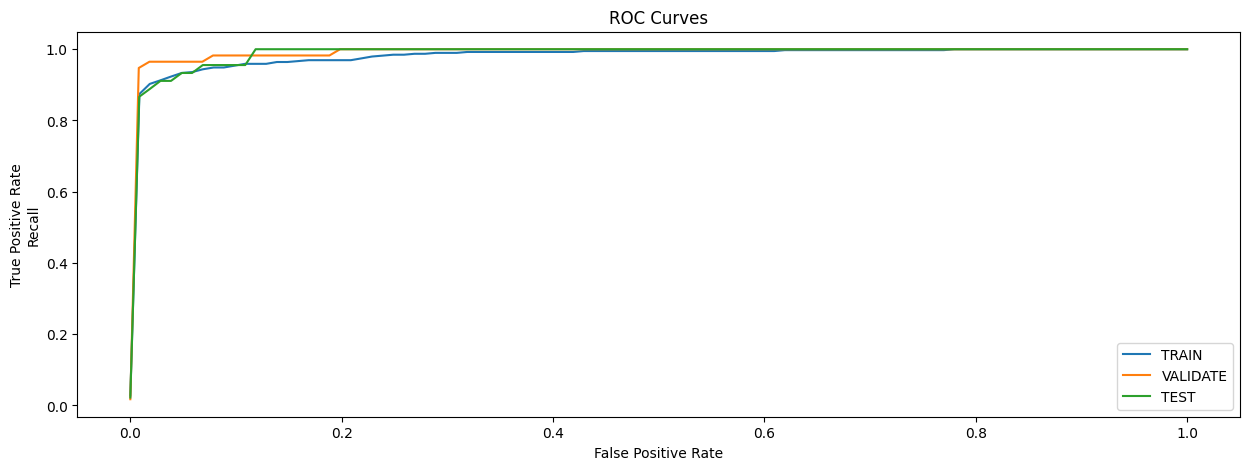

In [37]:
plt.figure(figsize=(15,5))
plt.plot(train_roc['false_positive_rate'], train_roc['recall'], label='TRAIN')
plt.plot(val_roc['false_positive_rate'], val_roc['recall'], label='VALIDATE')
plt.plot(test_roc['false_positive_rate'], test_roc['recall'], label='TEST')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate\nRecall')
plt.title('ROC Curves')
plt.legend()
plt.show()

---
## Predictions With BigQuery ML (BQML)

Create a pandas dataframe with retrieved predictions for the test data in the table using [ML.PREDICT](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-predict):

In [38]:
query = f"""
SELECT *
FROM ML.PREDICT (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TEST')
  )
"""
pred = bq.query(query = query).to_dataframe()

Review columns from the predictions - note that the query added columns with prefix `predicted_`

In [39]:
pred.columns

Index(['predicted_Class', 'predicted_Class_probs', 'Time', 'V1', 'V2', 'V3',
       'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14',
       'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24',
       'V25', 'V26', 'V27', 'V28', 'Amount', 'Class', 'transaction_id',
       'splits'],
      dtype='object')

Print the first few rows for the columns related to the actual and predicted values:

In [40]:
pred[[VAR_TARGET, f'predicted_{VAR_TARGET}', f'predicted_{VAR_TARGET}_probs', 'splits']].head()

,Class,predicted_Class,predicted_Class_probs,splits
0,0,0,"[{'label': 1, 'prob': 0.01771644802024108}, {'...",TEST
1,0,0,"[{'label': 1, 'prob': 0.06768691443186707}, {'...",TEST
2,0,0,"[{'label': 1, 'prob': 0.2517095946441859}, {'l...",TEST
3,0,0,"[{'label': 1, 'prob': 0.027287823697052294}, {...",TEST
4,0,0,"[{'label': 1, 'prob': 0.397623089391459}, {'la...",TEST


Notice the nested dictionary for predicted probabilities.  In BigQuery this is a Record type structure with nested fields for `label` and `prob`.  This is returned to the pandas dataframe as a nested dictionary.

The following code sorts the dictionary for the first record by `prob`:

In [41]:
exec('temp = pred.predicted_'+VAR_TARGET+'_probs[0]')
[sorted(x, key = lambda x: x['label']) for x in [temp]]

[[{'label': 0, 'prob': 0.9822835519797589},
  {'label': 1, 'prob': 0.01771644802024108}]]

---
## Custom Eval Metrics
Retrieve the predictions to a local dataframe and use [scikit-learn](https://scikit-learn.org/stable/index.html) metrics [fuctions](https://scikit-learn.org/stable/modules/model_evaluation.html) to do model evaluation.

In [42]:
metrics.confusion_matrix(list(pred[f'{VAR_TARGET}']), list(pred[f'predicted_{VAR_TARGET}']))

array([[27904,   519],
       [    5,    40]])

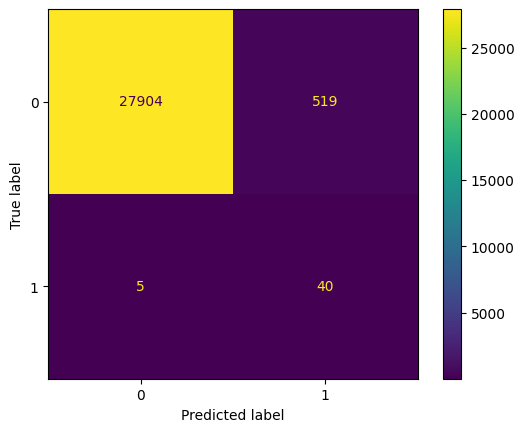

In [43]:
disp = metrics.ConfusionMatrixDisplay(
    confusion_matrix = metrics.confusion_matrix(list(pred[f'{VAR_TARGET}']), list(pred[f'predicted_{VAR_TARGET}']))
)
disp.plot()

In [44]:
metrics.accuracy_score(list(pred[f'{VAR_TARGET}']), list(pred[f'predicted_{VAR_TARGET}']))

0.9815933679921315

In [45]:
print(metrics.classification_report(list(pred[f'{VAR_TARGET}']), list(pred[f'predicted_{VAR_TARGET}'])))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     28423
           1       0.07      0.89      0.13        45

    accuracy                           0.98     28468
   macro avg       0.54      0.94      0.56     28468
weighted avg       1.00      0.98      0.99     28468



---
## Explanations
[Built-in](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-xai-overview) capabilities to understand how features contributed to predictions both individually (local) and overall (global).

### Local Explainability
Retrieve feature attribution values to interpret each features contribution to a prediction relative to the baseline prediction using [ML.EXPLAIN_PREDICT](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-explain-predict).

In [46]:
query = f"""
SELECT *
FROM ML.EXPLAIN_PREDICT (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TEST'), STRUCT(10 as top_k_features)
  )
"""
explain = bq.query(query = query).to_dataframe()

In [47]:
explain.head()

,predicted_Class,probability,top_feature_attributions,baseline_prediction_value,prediction_value,approximation_error,Time,V1,V2,V3,...,V23,V24,V25,V26,V27,V28,Amount,Class,transaction_id,splits
0,0,0.982284,"[{'feature': 'V4', 'attribution': -0.812634942...",-2.683264,-4.015387,0.0,76558,-0.465150,0.818433,1.326391,...,-0.290143,-0.387924,0.413861,0.813386,-0.130873,-0.047641,0.0,0,c14b4a94-6794-467b-880c-522dd45de66e,TEST
1,0,0.932313,"[{'feature': 'V4', 'attribution': 2.5146411447...",-2.683264,-2.622776,0.0,161428,-2.663819,2.806353,-0.005975,...,0.134870,0.255306,-0.448284,0.378887,-1.058233,-0.248913,0.0,0,5be0e4ce-cb9b-4962-aaa0-122c95976ee2,TEST
2,0,0.748290,"[{'feature': 'V4', 'attribution': 1.5896402914...",-2.683264,-1.089515,0.0,54207,1.199721,0.330359,0.658892,...,-0.125600,-0.128544,0.659757,0.112569,0.002388,0.012351,0.0,0,325d0d34-b2b2-4c30-9bdb-8270f60e0a9b,TEST
3,0,0.972712,"[{'feature': 'V4', 'attribution': 1.5074199587...",-2.683264,-3.573648,0.0,159888,-3.146402,2.543688,-0.328957,...,0.085183,0.212830,-0.312526,-0.248380,-2.731440,-0.754864,0.0,0,085879f7-8db9-48a2-b7c1-0ba5659d5206,TEST
4,0,0.602377,"[{'feature': 'V4', 'attribution': 2.4498408302...",-2.683264,-0.415379,0.0,129606,1.881873,0.216226,-0.175786,...,0.105719,-0.046391,0.039283,0.142767,-0.009026,-0.050938,0.0,0,e516b6cc-655b-4555-921e-20fa6aff6f67,TEST


Create a plot of feature attributions for a single prediction:

In [48]:
explanation = explain.iloc[0]['top_feature_attributions']

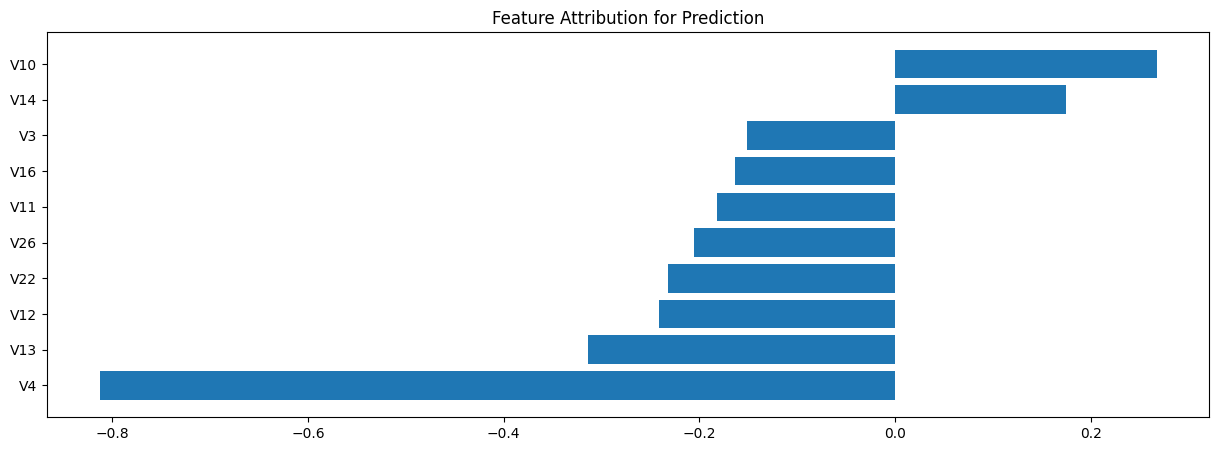

In [49]:
features = []
scores = []
for k in explanation:
    features.append(k['feature'])
    scores.append(k['attribution'])
features = [x for _, x in sorted(zip(scores, features))]
scores = sorted(scores)

plt.figure(figsize=(15,5))
plt.barh(features, scores)
plt.title('Feature Attribution for Prediction')
plt.show()

### Global Explainability
Retrieve the influence of each feature on the model with [ML.GLOBAL_EXPLAIN](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-global-explain).  

In [50]:
query = f"""
SELECT *
FROM ML.GLOBAL_EXPLAIN (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
"""
gexplain = bq.query(query = query).to_dataframe()

In [51]:
gexplain.head()

,feature,attribution
0,V4,0.653144
1,V14,0.487301
2,V12,0.394964
3,V10,0.213262
4,V22,0.201468


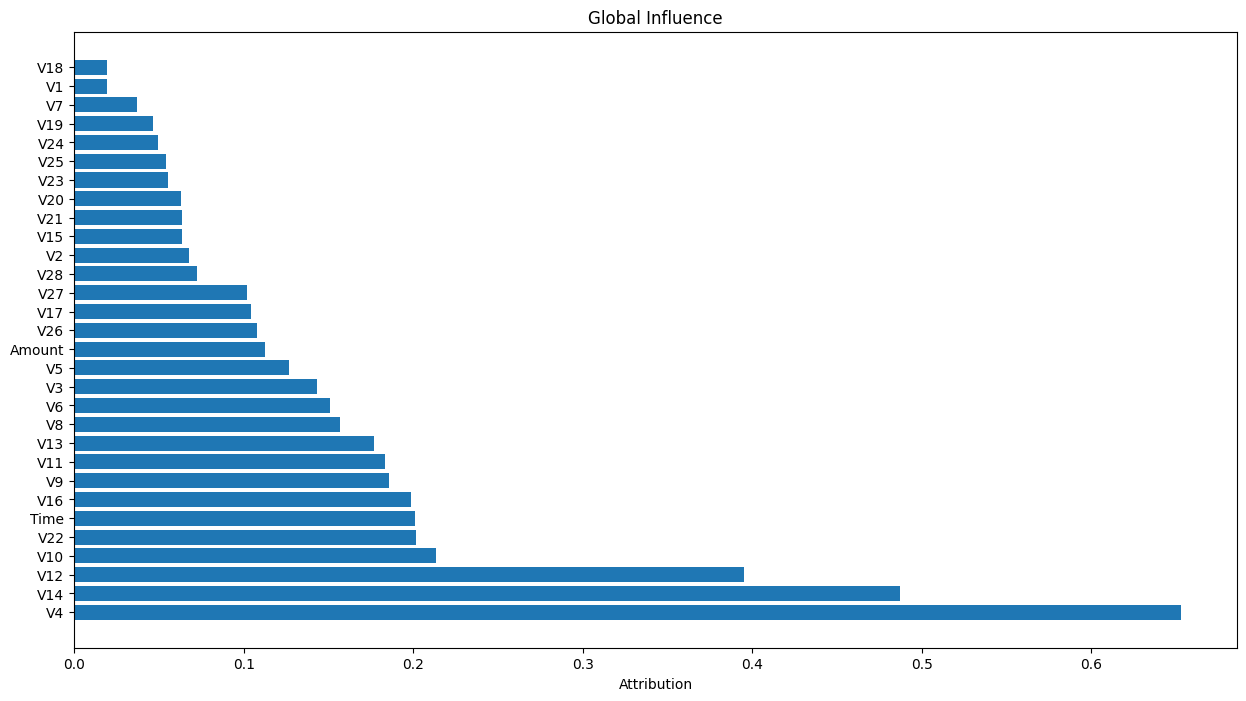

In [52]:
plt.figure(figsize=(15,8))
plt.barh(gexplain['feature'], gexplain['attribution'])
plt.title('Global Influence')
plt.xlabel('Attribution')
#plt.ylabel('Feature')
plt.show()

---
## Serving With Vertex AI

The training options for creating the model include registering the model the Vertex AI Automatically.  This makes deploying the model to a [Vertex AI Endpoint for online serving](https://cloud.google.com/vertex-ai/docs/general/deployment) very easy.

### Vertex AI Model Registry - Get Model

When these modes were trained in BigQuery ML they included options for registration in Vertex AI Model Registry.  This section shows how to retrieve the information from the model using the [Vertex AI Python Client](../Tips/aiplatform_notes.md).

References:
- [aiplatform.Model()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Model)

In [53]:
vertex_model = aiplatform.Model(model_name = f'bqml_{SERIES}_{EXPERIMENT}')
vertex_model.resource_name

'projects/239661236943/locations/us-central1/models/bqml_bqml_logistic-regression'

In [54]:
aiplatform.ModelEvaluation(
    evaluation_name = vertex_model.get_model_evaluation().resource_name
).to_dict()['metrics']['confusionMatrix']

{'annotationSpecs': [{'id': '0', 'displayName': '1'},
  {'id': '1', 'displayName': '0'}],
 'rows': [[55.0, 2.0], [507.0, 27728.0]]}

In [55]:
# note: this is blank since the model is managed by BQML and container is pre-specified
vertex_model.uri 

### Vertex AI Endpoint - Create or Retrieve

References:
- [aiplatform.Endpoint()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Endpoint)

In [56]:
if not aiplatform.Endpoint.list(filter = f"display_name={SERIES}"):
    endpoint = aiplatform.Endpoint.create(
        display_name = f"{SERIES}",
        labels = {'series' : f"{SERIES}"}
    )
    print(f"Endpoint Created: {endpoint.display_name}")
else:
    endpoint = aiplatform.Endpoint.list(filter = f"display_name={SERIES}")[0]
    print(f"Endpoint Found: {endpoint.display_name}")

Creating Endpoint
Create Endpoint backing LRO: projects/239661236943/locations/us-central1/endpoints/7988912948955316224/operations/4683911219269074944
Endpoint created. Resource name: projects/239661236943/locations/us-central1/endpoints/7988912948955316224
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/239661236943/locations/us-central1/endpoints/7988912948955316224')
Endpoint Created: bqml


In [57]:
endpoint.display_name

'bqml'

In [61]:
endpoint.traffic_split

{}

In [62]:
deployed_models = endpoint.list_models()
deployed_models

[]

### Deploy Model To Vertex AI Endpoint

**NOTE: This can take 15+ minutes to complete.**

Reference:
- [aiplatform.Endpoint.deploy()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Endpoint#google_cloud_aiplatform_Endpoint_deploy)

In [63]:
endpoint.deploy(
    model = vertex_model,
    deployed_model_display_name = vertex_model.display_name,
    traffic_percentage = 100,
    machine_type = 'n1-standard-2',
    min_replica_count = 1,
    max_replica_count = 1
)

Deploying Model projects/239661236943/locations/us-central1/models/bqml_bqml_logistic-regression to Endpoint : projects/239661236943/locations/us-central1/endpoints/7988912948955316224
Deploy Endpoint model backing LRO: projects/239661236943/locations/us-central1/endpoints/7988912948955316224/operations/1645107370700832768
Endpoint model deployed. Resource name: projects/239661236943/locations/us-central1/endpoints/7988912948955316224


---
## Predictions With Vertex AI Endpoint

### Retrieve Records For Prediction

In [89]:
n = 10
pred = bq.query(
    query = f"""
        SELECT * EXCEPT({VAR_TARGET}, {VAR_OMIT}, splits)
        FROM {BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}
        WHERE splits='TEST'
        LIMIT {n}
        """
).to_dataframe()

Shape as instances: dictionaries of key:value pairs for only features used in model

In [90]:
newobs = pred.to_dict(orient = 'records')

In [91]:
newobs[0]

{'Time': 76558,
 'V1': -0.4651502457401,
 'V2': 0.8184333410066371,
 'V3': 1.32639138005421,
 'V4': -1.34520097945899,
 'V5': 0.584114602142683,
 'V6': -0.683283568598094,
 'V7': 0.8560224069325509,
 'V8': -0.17826517058350796,
 'V9': -0.537311322971362,
 'V10': -0.9631806924953091,
 'V11': -0.895453700125653,
 'V12': 0.449282865521539,
 'V13': 1.54880921738484,
 'V14': -0.24186601385748896,
 'V15': 0.37375305783561796,
 'V16': 0.5747296510932199,
 'V17': -0.880060466188634,
 'V18': -0.498862257527863,
 'V19': -0.0806021151076021,
 'V20': 0.04927507007025,
 'V21': -0.23550599216180002,
 'V22': -0.719604821296463,
 'V23': -0.290142610363049,
 'V24': -0.38792388871900796,
 'V25': 0.41386118833209,
 'V26': 0.8133863823373348,
 'V27': -0.130872651979088,
 'V28': -0.0476414298012019,
 'Amount': 0.0}

### Get Predictions: Python Client

In [92]:
prediction = endpoint.predict(instances = newobs[0:1])
prediction

Prediction(predictions=[{'predicted_Class': ['0'], 'Class_values': ['1', '0'], 'Class_probs': [0.01771644809646814, 0.9822835519035319]}], deployed_model_id='6225058803491012608', model_version_id='1', model_resource_name='projects/239661236943/locations/us-central1/models/bqml_bqml_logistic-regression', explanations=None)

In [93]:
prediction.predictions[0]

{'predicted_Class': ['0'],
 'Class_values': ['1', '0'],
 'Class_probs': [0.01771644809646814, 0.9822835519035319]}

In [94]:
np.argmax(prediction.predictions[0])

0

### Get Predictions: REST
Reference:
- [POST https://{REGION}-aiplatform.googleapis.com/v1/{endpoint}:predict](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform_v1.services.prediction_service.PredictionServiceClient#google_cloud_aiplatform_v1_services_prediction_service_PredictionServiceClient_predict)

Prepare request:

In [95]:
with open(f'{DIR}/request.json','w') as file:
    file.write(json.dumps({"instances": newobs[0:1]}))

Prediction:

In [96]:
prediction = !curl -X POST \
-H "Authorization: Bearer "$(gcloud auth application-default print-access-token) \
-H "Content-Type: application/json; charset=utf-8" \
-d @{DIR}/request.json \
https://{REGION}-aiplatform.googleapis.com/v1/{endpoint.resource_name}:predict

prediction

['  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current',
 '                                 Dload  Upload   Total   Spent    Left  Speed',
 '',
 '  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0',
 '100  1246    0   453  100   793   1903   3332 --:--:-- --:--:-- --:--:--  5257',
 '{',
 '  "predictions": [',
 '    {',
 '      "predicted_Class": [',
 '        "0"',
 '      ],',
 '      "Class_probs": [',
 '        0.017716448096468142,',
 '        0.98228355190353189',
 '      ],',
 '      "Class_values": [',
 '        "1",',
 '        "0"',
 '      ]',
 '    }',
 '  ],',
 '  "deployedModelId": "6225058803491012608",',
 '  "model": "projects/239661236943/locations/us-central1/models/bqml_bqml_logistic-regression",',
 '  "modelDisplayName": "bqml_bqml_logistic-regression",',
 '  "modelVersionId": "1"',
 '}']

Format raw prediction response using JSON:

### Get Predictions: gcloud (CLI)
Reference:
- [gcloud ai endpoints predict](https://cloud.google.com/sdk/gcloud/reference/ai/endpoints/predict)

Prepare request:

In [97]:
with open(f'{DIR}/request.json','w') as file:
    file.write(json.dumps({"instances": newobs[0:1]}))

Prediction:

In [98]:
prediction = !gcloud beta ai endpoints predict {endpoint.name.rsplit('/',1)[-1]} --region={REGION} --json-request={DIR}/request.json
prediction

['Using endpoint [https://us-central1-prediction-aiplatform.googleapis.com/]',
 "[{'Class_probs': [0.01771644809646814, 0.9822835519035319], 'Class_values': ['1', '0'], 'predicted_Class': ['0']}]"]

---
## Export Model

The model created in BigQuery ML can be exported to their native model types save files.  This process saves the model artifacts in GCS where they can be use anywhere they are needed.  For instance, they could be imported into the Vertex AI Model Registry for use in online and batch serving - however, this process is automated with the training options use above.

### Export the BigQuery Model


The models trained in BQML can be exported from BigQuery to GCS:

Reference:
- [Exporting Models](https://cloud.google.com/bigquery-ml/docs/exporting-models)

In [99]:
query = f"""
EXPORT MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`
    OPTIONS (URI = 'gs://{BUCKET}/{SERIES}/{EXPERIMENT}/models/{TIMESTAMP}/model')
"""
export = bq.query(query = query)
export.result()

In [100]:
(export.ended - export.started).total_seconds()

22.478

In [101]:
listing = !gsutil ls gs://{BUCKET}/{SERIES}/{EXPERIMENT}/models/{TIMESTAMP}/model
listing

['gs://learned-pottery-399802/bqml/logistic-regression/models/20231019060415/model/',
 'gs://learned-pottery-399802/bqml/logistic-regression/models/20231019060415/model/explanation_metadata.json',
 'gs://learned-pottery-399802/bqml/logistic-regression/models/20231019060415/model/fingerprint.pb',
 'gs://learned-pottery-399802/bqml/logistic-regression/models/20231019060415/model/saved_model.pb',
 'gs://learned-pottery-399802/bqml/logistic-regression/models/20231019060415/model/variables/']

In [102]:
print(f"View the export in the console:\nhttps://console.cloud.google.com/storage/browser/{BUCKET}/{SERIES}/{EXPERIMENT}/models/{TIMESTAMP}/model?project={PROJECT_ID}")

View the export in the console:
https://console.cloud.google.com/storage/browser/learned-pottery-399802/bqml/logistic-regression/models/20231019060415/model?project=learned-pottery-399802


### Detect The Model Types Framework

In [103]:
filetype = {'pb': 'TensorFlow', 'bst': 'XGBoost'}

filetypes = [filetype[f.split('.')[-1]] for f in listing if f.split('.')[-1] in ['pb','bst']]
if len(list(set(filetypes))) == 1:
    framework = filetypes[0]
    print(f'framework = {framework}')
else:
    raise TypeError(f"Model Type Undeteremined!! Review the contents of of 'listing = {listing}'.")

framework = TensorFlow


In [104]:
list(set(filetypes))

['TensorFlow']

---
## Remove Resources

The following cells have commented out statements that can be used to remove resources created by this notebook.  Other notebooks in the repository will reusue the same endpoint so it may be desired to not remove the endpoint if you plan to run additional notebooks.  Otherwise, please removed the endpoint to prevent ongoing cost from hosting the models on Vertex AI Endpoints.

Similarly, if you want to remove the model from BQML to prevent the minimal storage cost it will automatically be removed from Vertex AI Model Registry as well.

In [107]:
# delete endpoint, use `force` incase models are deployed or undeploy them first
endpoint.delete(force = True)

Undeploying Endpoint model: projects/239661236943/locations/us-central1/endpoints/7988912948955316224
Undeploy Endpoint model backing LRO: projects/239661236943/locations/us-central1/endpoints/7988912948955316224/operations/5123012182937698304
Endpoint model undeployed. Resource name: projects/239661236943/locations/us-central1/endpoints/7988912948955316224
Deleting Endpoint : projects/239661236943/locations/us-central1/endpoints/7988912948955316224
Delete Endpoint  backing LRO: projects/239661236943/locations/us-central1/operations/1574175676569747456
Endpoint deleted. . Resource name: projects/239661236943/locations/us-central1/endpoints/7988912948955316224


In [109]:
# delete models created in BQ with BQML - this also removes them from Vertex AI Model Registry
import time
time.sleep(60)
bq.delete_model(model)

NotFound: 404 DELETE https://bigquery.googleapis.com/bigquery/v2/projects/learned-pottery-399802/datasets/fraud/models/bqml_logistic-regression_20231019060415?prettyPrint=false: Not found: Model learned-pottery-399802:fraud.bqml_logistic-regression_20231019060415